In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-ea1f641c-4cde-9024-8d04-b12ea5532de7)


In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
import matplotlib.pyplot as plt
import json
import glob2
from tqdm import tqdm
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

def read_dataset(globpath):
# 	"""
# 	Read training dataset or validation dataset.
# 	:param path: The path of dataset.
# 	:return: The list of filenames.
# 	"""
  image_list = sorted(glob2.glob(globpath))

  return image_list

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extract images from drive, crop images, then transfer to appropriate folder -- train
!unzip /content/drive/Shareddrives/S22_CSCI_5561_Project/Data/train1.zip > /dev/null

In [ ]:
!unzip /content/drive/Shareddrives/S22_CSCI_5561_Project/Data/train2.zip > /dev/null

In [ ]:
!unzip /content/drive/Shareddrives/S22_CSCI_5561_Project/Data/train3.zip > /dev/null

In [ ]:
# extract images from drive, crop images, then transfer to appropriate folder -- val
!unzip /content/drive/Shareddrives/S22_CSCI_5561_Project/Data/val.zip > /dev/null

In [ ]:
# extract testing data
!unzip /content/drive/Shareddrives/S22_CSCI_5561_Project/Data/test_dataset/test.zip > /dev/null

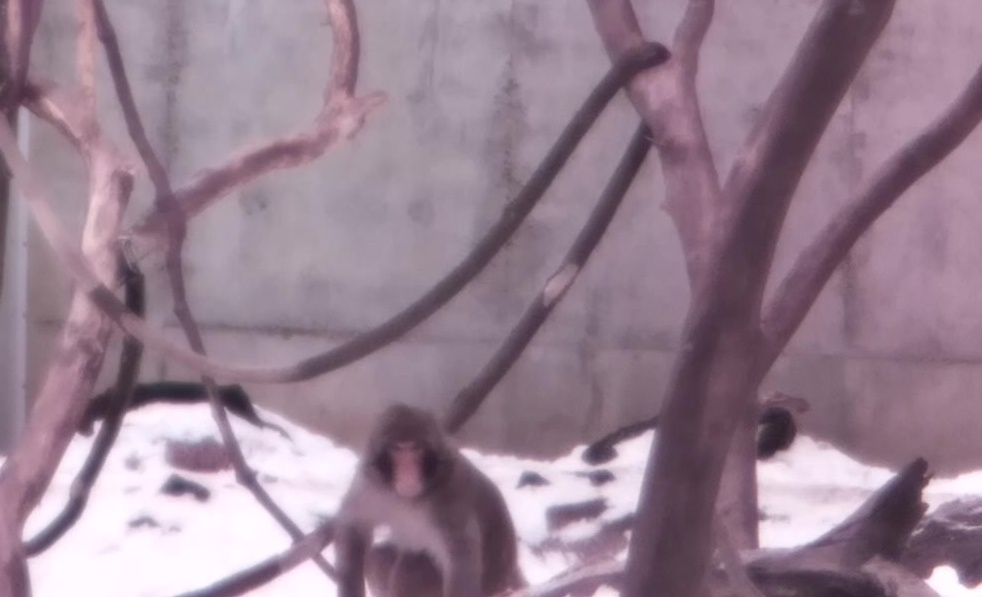

In [ ]:
image_list=read_dataset('/content/test/*.jpg')
pil_image = PIL.Image.open(image_list[0]).convert('RGB')
display(pil_image)

In [ ]:
!mkdir test_sm

In [ ]:
import os
import math
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
indy=0
while indy<len(image_list):
  ite=image_list[indy]

  new_path=os.path.basename(ite)
  new_path='/content/test_sm/'+new_path
  new_path=os.path.normpath(new_path)

  pil_image = PIL.Image.open(ite).convert('RGB')
  width,height=pil_image.size
  dupe_image=pil_image.copy()
  pil_image=pil_image.resize((int(width/math.sqrt(4)),int(height/math.sqrt(4))))

  img_original = numpy.array(dupe_image)
  img_data = pil_to_tensor(pil_image)
  singleton_batch = {'img_data': img_data[None].cuda()}
  output_size = img_data.shape[1:]

  with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)

  _, pred = torch.max(scores, dim=1)
  pred = pred.cpu()[0].numpy()
  pred[pred==12]=255
  pred[pred==126]=255
  pred[pred!=255]=100
  pred=pred.astype(numpy.uint8)
  pred=PIL.Image.fromarray(pred)
  pred=pred.filter(PIL.ImageFilter.GaussianBlur(20))

  pred=pred.resize((width,height))

  pred=numpy.asarray(pred)
  pred=pred.astype(float)
  pred/=255

  new_image=numpy.array(img_original)
  new_image=new_image.astype(float)
  new_image/=255
  new_image[:,:,0]=numpy.multiply(new_image[:,:,0],pred)
  new_image[:,:,1]=numpy.multiply(new_image[:,:,1],pred)
  new_image[:,:,2]=numpy.multiply(new_image[:,:,2],pred)
  new_image*=255
  new_image=new_image.astype(numpy.uint8)
  new_image=PIL.Image.fromarray(new_image)

  new_image.save(new_path)

  indy+=1


In [ ]:
!zip -r '/content/test_sm.zip' '/content/test_sm/' > /dev/null

In [ ]:
!cp '/content/test_sm.zip' '/content/drive/Shareddrives/S22_CSCI_5561_Project/Data'